In [1]:
from tqdm import tqdm

# %matplotlib notebook
from keithley2600 import Keithley2600
from pmu_som import pmu_ctrl, pmu_cal, pmu_calc, pmu_def
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from si_prefix import si_format

try:
    del(p.c)
except:
    pass

k = Keithley2600('GPIB0::17::INSTR', visa_library='')
k.smua.reset()
k.smub.reset()

# p = communicator.communicator(False)
p = pmu_ctrl.pmu()

k.smua.measure.nplc = 3 # 0.001 to 25
k.smub.measure.nplc = 25 # 0.001 to 25

# k.smua.source.highc = k.smua.ENABLE
# k.smua.sense = k.smua.SENSE_REMOTE
k.smua.source.output = k.smua.OUTPUT_OFF
k.smub.source.output = k.smub.OUTPUT_OFF
k.display.screen = k.display.USER
k.display.clear()
k.display.settext("Ready to do $BStuff$N")
k.display.settext("ctrl from adc_testings.ipynb")

k.beeper.enable = k.beeper.ON
#k.play_chord(notes=("G5", "F5", "C5", "C6"), durations=0.1)
# k.beeper.enable = k.beeper.OFF

p.change_sys_ctrl({
    "DUTGND/CH" : 1,
    "INT10K"    : 1
})

# Memory interaction

In [3]:
#######################
#### caldata mem to pmu
#######################

#create adr list
adr_list = list()
for ch in range(4):
    for c_m in range(2):
        for i, reg_name in enumerate(list(pmu_def.DAC_REG_TABLE.keys())[1:]):
            adr = 0
            adr |= ch << 6
            adr |= c_m << 5
            adr |= i << 1
            adr_list.append(adr)
        
        adr |= 0x1F
        adr -= 1
        adr_list.append(adr)

#read data from memory
rd_cal_list = p.mem_read_data(adr_list)


#write data do dac reg
for ch in range(4):
    for c_m in range(2):
        for i, reg_name in enumerate(list(pmu_def.DAC_REG_TABLE.keys())[1:]):
            adr = 0
            adr |= ch << 6
            adr |= c_m << 5
            adr |= i << 1
            
            if c_m:
                p.channels[ch].write_dac(rd_cal_list[adr], reg_name, reg="C")
            else:
                p.channels[ch].write_dac(rd_cal_list[adr], reg_name, reg="M")
            
            sleep(0.1)
        adr |= 0x1F
        adr -= 1
        # mem_list[adr] = X1.loc[ch, "Offset"]
        p.channels[ch].write_dac(rd_cal_list[adr], "Offset")
        sleep(0.1)


In [2]:
ch=0

p.write_all_PMU_REGS(0x1E060)

k.display.screen            = k.display.SMUA
k.display.smua.measure.func = k.display.MEASURE_DCVOLTS
    
k.smua.measure.rangev       = 15
k.smua.measure.autorangei   = k.smua.AUTORANGE_ON
k.smua.measure.nplc         = 1
    
k.smua.source.func          = k.smua.OUTPUT_DCAMPS
k.smua.source.leveli        = 0
k.smua.source.limiti        = 10e-3
k.smua.source.limitv        = 14
# k.smua.source.output        = k.smua.OUTPUT_ON

p.change_sys_ctrl({
        "DUTGND/CH" : 1,
        "INT10K"    : 1,
        "GAIN"      : 2,
        "TMP ENABLE": 1,
        "TMP"       : 3 # Thermal shutdown at 100°C
    })
    
p.channels[ch].change_pmu_reg({
    "CH EN" : 1,     #Channel enable
    "FORCE" : 0,     #FV
    "C"     : 3,
    # "MEAS"  : 2,    #Temp Sensor (25°C = 1.5V | 4.6mV/°C)
    "MEAS"  : 1,    #VSens
    # "MEAS"  : 0,    #ISens
    "SS0"   : 1,
    "SF0"   : 1,
    "FIN"  : 1
})

In [3]:
p.channels[0].write_dac(pmu_calc.v_to_dac(1), "FIN_U")

In [4]:
tmp_sens_cnf = 0x8232
print("ADC-ID  = 0x%04X" % p.c.command("adc_read -r 7 -l 16", read=True))
p.c.command("adc_write -r 0x30 -l 24 -d 0xFFFFFF")
OFFSET0 = p.c.command("adc_read -r 0x30 -l 24", read=True) - 0x800000
GAIN0 = p.c.command("adc_read -r 0x38 -l 24", read=True) / 0x400000
VREF = 2.5

print("OFFSET0 = 0x%i" % OFFSET0)
print("GAIN0   = %f" % GAIN0)

def volt_conversion(val, Bipolar=True, gain=GAIN0, offset=OFFSET0):
    res = val#/gain

    if Bipolar:
        res -= 0x800000
    else:
        res /= 2
    
    # res += offset
    res *= VREF/0.75/(2**23)
    
    return res

ADC-ID  = 0x0CDE
OFFSET0 = 0x8388607
GAIN0   = 4.000000


In [9]:
#do internal zero scale calibration for adc0
d =  1<<15
d |= 6<<4 # internal offset cal

p.c.command("adc_write -r 0x01 -l 16 -d %i" % d)

In [5]:
# single conversion
# p.c.command("adc_write -r 0x30 -l 24 -d 0x800000") #shift offset
p.channels[0].write_dac(pmu_calc.v_to_dac(5), "FIN_U")

bipol = 1

d =  1<<15
d |= 0<<12
d |= 0<<5 # inp = ain0
d |= 4<<0 # inn = ref-
p.c.command("adc_write -r 0x10 -l 16 -d %i" % d) # ch setup
d =  bipol<<12 # bipol
d |= 1<<11 # refbuf+
d |= 1<<10 # refbuf-
d |= 1<< 9 # ainbuf+
d |= 1<< 8 # ainbuf-
d |= 2<<4  # ref_sel = int
p.c.command("adc_write -r 0x20 -l 16 -d %i" % d) # setup con

p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
print("0x%06X"%raw)
conv = volt_conversion(raw, bipol)
print("A0_in = %sV" % si_format(conv, precision=3))


0x000000
A0_in = -3.333 V


In [27]:
p.channels[0].decode_pmu_reg()

{'CH EN': 0,
 'FORCE': 0,
 'C': 3,
 'MEAS': 1,
 'FIN': 1,
 'SF0': 1,
 'SS0': 1,
 'CL': 0,
 'CPOLH': 0,
 'COMPARE V/I': 0,
 'LTMPALMn': 1,
 'TMPALMn': 1}

100%|██████████| 25/25 [00:03<00:00,  6.90it/s]



 adc_measurements 
 [-1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.33333333]

 smu_measurements 
 [-11.0882    -10.1632     -9.2382     -8.31306    -7.38806    -6.46297
  -5.5379     -4.61297    -3.68795    -2.76289    -1.83788    -0.91289
   0.0120592   0.937052    1.86222     2.78717     3.71213     4.63723
   5.56229     6.48702     7.41191     8.33696     9.26209    10.187
  11.1121   ]


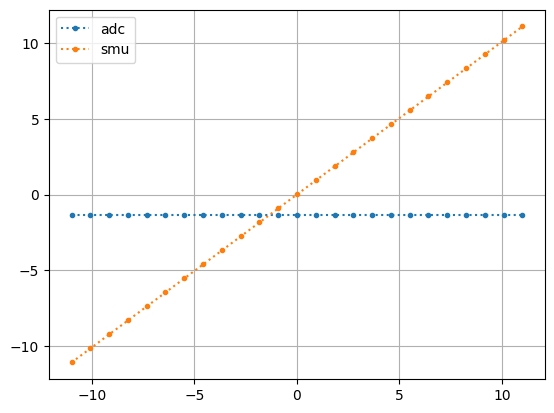

In [6]:
p.change_sys_ctrl({
        "DUTGND/CH" : 1,
        "INT10K"    : 1,
        "GAIN"      : 3, #1 #3
        "TMP ENABLE": 1,
        "TMP"       : 3 # Thermal shutdown at 100°C
})

k.smua.source.output        = k.smua.OUTPUT_ON
adc_meas = list()
smu_meas = list()
v_set = np.linspace(-11, 11, 25)
for v in tqdm(v_set):
    # k.smua.source.levelv = v
    p.channels[0].write_dac(pmu_calc.v_to_dac(v), "FIN_U")
    # sleep(0.1)
    p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
    # sleep(0.1)
    raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
    conv = volt_conversion(raw, bipol)
    conv *= 2/5     # seistive devider
    # conv *= 10      # gain
    adc_meas.append(conv)
    smu_meas.append(k.smua.measure.v())
    # print("A0_in = %sV" % si_format(conv, precision=3))
    
adc_meas = np.array(adc_meas)
smu_meas = np.array(smu_meas)

plt.plot(v_set,adc_meas, ".:", label="adc")
plt.plot(v_set,smu_meas, ".:", label="smu")
print("\n adc_measurements \n",adc_meas)
print("\n smu_measurements \n",smu_meas)

plt.legend()
plt.grid()
plt.show()
k.smua.source.output        = k.smua.OUTPUT_OFF

In [9]:
p.reset()

In [5]:
# Trying Internal Calibration
p.change_sys_ctrl({
     "DUTGND/CH" : 1,
     "INT10K"    : 1,
     "GAIN"      : 3, #1 #3
     "TMP ENABLE": 1,
     "TMP"       : 3 # Thermal shutdown at 100°C

})

k.smua.source.output = k.smua.OUTPUT_ON
k.display.settext("Ready to do $BStuff$N")
k.display.settext("Trying ADC Internal Calibration")

adc_meas = list()
smu_meas = list()
v_set = np.linspace(-11, 11, 25)
for v in tqdm(v_set):
    # k.smua.source.levelv = v
    p.channels[0].write_dac(pmu_calc.v_to_dac(v), "FIN_U")
    # sleep(0.1)
    p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
    # sleep(0.1)
    raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
    conv = volt_conversion(raw, bipol)
    conv *= 2/5     # seistive devider
    # conv *= 10      # gain
    adc_meas.append(conv)
    smu_meas.append(k.smua.measure.v())
    # print("A0_in = %sV" % si_format(conv, precision=3))
    
adc_meas = np.array(adc_meas)
smu_meas = np.array(smu_meas)

plt.plot(v_set,adc_meas, ".:", label="adc")
plt.plot(v_set,smu_meas, ".:", label="smu")
plt.legend()
plt.grid()
plt.show()
print("\n adc_measurements \n",adc_meas)
print("\n smu_measurements \n",smu_meas)

sleep(0.5)
# Comparing Outputs for INTERNAL ZERO-SCALE CALIBRATION MODE,SYSTEM ZERO-SCALE CALIBRATION MODE AND SYSTEM FULL-SCALE CALIBRATION MODE

# Trying Internal Zero-Scale Calibration

d =  1<<15
d |= 5<<4 # internal offset cal

p.c.command("adc_write -r 0x01 -l 16 -d %i" % d)
OFFSET0 = p.c.command("adc_read -r 0x30 -l 24", read=True) - 0x800000
GAIN0 = p.c.command("adc_read -r 0x38 -l 24", read=True) / 0x400000

print(" \nChecking if the M and C Values are changed in the registers after Internal Zero Scale Calibration")
print("\n Offset after Internal zero Sccale calibration",OFFSET0)
print("\n gain after internal zero scale calibration  ", GAIN0)

adc_meas_after_cal = list()
smu_meas_after_cal = list()

# Doing Measurement to compare accuracy with SMU

for v in tqdm(v_set):
    p.channels[0].write_dac(pmu_calc.v_to_dac(v),"FIN_U")
    p.c.command("adc_write -r 0x01 -l 16 -d 0x8010")

    raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
    conv = volt_conversion(raw, bipol)
    conv *= 2/5     # seistive devider  - not exactly sure , why we are using this

    adc_meas_after_cal.append(conv)
    smu_meas_after_cal.append(k.smua.measure.v())


adc_meas_after_cal_internal_zero_scale_calibration = np.array(adc_meas_after_cal)
smu_meas_after_cal_internal_zero_scale_calibration = np.array(smu_meas_after_cal)

plt.plot(v_set,adc_meas_after_cal_internal_zero_scale_calibration,".:", label = "adc")
plt.plot(v_set,smu_meas_after_cal_internal_zero_scale_calibration,".:", label = "smu")
plt.legend()
plt.grid()
plt.show()
print("\n adc_meas_after_cal_internal_zero_scale_calibrati \n",adc_meas_after_cal_internal_zero_scale_calibration)
print("\n smu_meas_after_cal_internal_zero_scale_calibration \n",smu_meas_after_cal_internal_zero_scale_calibration)
k.smua.source.output = k.smua.OUTPUT_OFF

sleep(0.5)

# Trying System OFFSET Calibration

d = 0X8038

p.c.command("adc_write -r 0x01 -l 16 -d %i" % d)

OFFSET0 = p.c.command("adc_read -r 0x30 -l 24", read=True) - 0x800000
GAIN0 = p.c.command("adc_read -r 0x38 -l 24", read=True) / 0x400000

print(" \nChecking if the M and C Values are changed in the registers after Internal Zero Scale Calibration")
print("\n Offset after Internal zero Sccale calibration",OFFSET0)
print("\n gain after internal zero scale calibration  ", GAIN0)

# adc_meas_after_cal_system_offset_calibration = list()
# smu_meas_after_cal_system_offset_calibration = list()

# # Doing Measurement to compare accuracy with SMU

# for v in tqdm(v_set):
#     p.channels[0].write_dac(pmu_calc.v_to_dac(v),"FIN_U")
#     p.c.command("adc_write -r 0x01 -l 16 -d 0x8010")

#     raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
#     conv = volt_conversion(raw, bipol)
#     conv *= 2/5     # seistive devider  - not exactly sure , why we are using this

#     adc_meas_after_cal_system_offset_calibration.append(conv)
#     smu_meas_after_cal_system_offset_calibration.append(k.smua.measure.v())

#     plt.plot(v_set,adc_meas_after_cal_system_offset_calibration,".:", label = "adc")
#     plt.plot(v_set,smu_meas_after_cal_system_offset_calibration,".:", label = "smu")
#     plt.legend()
#     plt.grid()
#     plt.show()
#     print("\n adc_meas_after_cal_internal_zero_scale_calibrati \n",adc_meas_after_cal_system_offset_calibration)
#     print("\n smu_meas_after_cal_internal_zero_scale_calibration \n",smu_meas_after_cal_system_offset_calibration)
#     k.smua.source.output = k.smua.OUTPUT_OFF



























  0%|          | 0/25 [00:00<?, ?it/s]


NameError: name 'bipol' is not defined

In [ ]:
# Trying Internal Calibration
p.change_sys_ctrl({
     "DUTGND/CH" : 1,
     "INT10K"    : 1,
     "GAIN"      : 3, #1 #3
     "TMP ENABLE": 1,
     "TMP"       : 3 # Thermal shutdown at 100°C

})

k.smua.source.output = k.smua.OUTPUT_ON
k.display.settext("Ready to do $BStuff$N")
k.display.settext("Trying ADC Internal Calibration")

adc_meas = list()
smu_meas = list()
v_set = np.linspace(-11, 11, 25)
for v in tqdm(v_set):
    # k.smua.source.levelv = v
    p.channels[0].write_dac(pmu_calc.v_to_dac(v), "FIN_U")
    # sleep(0.1)
    p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
    # sleep(0.1)
    raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
    conv = volt_conversion(raw, bipol)
    conv *= 2/5     # seistive devider
    # conv *= 10      # gain
    adc_meas.append(conv)
    smu_meas.append(k.smua.measure.v())
    # print("A0_in = %sV" % si_format(conv, precision=3))
    
adc_meas = np.array(adc_meas)
smu_meas = np.array(smu_meas)

plt.plot(v_set,adc_meas, ".:", label="adc")
plt.plot(v_set,smu_meas, ".:", label="smu")
plt.legend()
plt.grid()
plt.show()
print("\n adc_measurements \n",adc_meas)
print("\n smu_measurements \n",smu_meas)


In [13]:
print(adc_meas)

[-1.32769378 -1.28862158 -1.24953381 -1.21043237 -1.17132521 -1.13222949
 -1.09308227 -1.05397701 -1.01484919 -0.97571929 -0.93665155 -0.89753532
 -0.858476   -0.81930399 -0.78022528 -0.74106693 -0.70200332 -0.66287867
 -0.62376404 -0.58465131 -0.54555305 -0.5064586  -0.46732934 -0.42821439
 -0.38911994]


In [14]:
print(smu_meas)

[-11.0891    -10.1639     -9.23882    -8.3137     -7.38866    -6.4636
  -5.53838    -4.6134     -3.6883     -2.76312    -1.83815    -0.913048
   0.0119209   0.936985    1.86217     2.78718     3.7122      4.63735
   5.56249     6.48722     7.41222     8.33727     9.26247    10.1875
  11.1127   ]


In [29]:
# measure_temperature
p.c.command("adc_write -r 0x10 -l 16 -d %i" %(tmp_sens_cnf))
p.c.command("adc_write -r 0x01 -l 16 -d 0x8010")
sleep(0.1)
tmp_raw = p.c.command("adc_read -r 0x44 -l 24", True)
print("0x%06X" % tmp_raw)

tmp_volt = volt_conversion(tmp_raw, True)
print(tmp_volt)

tmp = (tmp_volt/477e-6) - 273.15
print("T = %f°C" % tmp)

0x873B03
0.1882946491241455
T = 121.597692°C


In [46]:
p.reset()


OFFSET0_without_calibration -1836197

GAIN0_without_calibration 1.3334221839904785


100%|██████████| 25/25 [00:03<00:00,  6.97it/s]


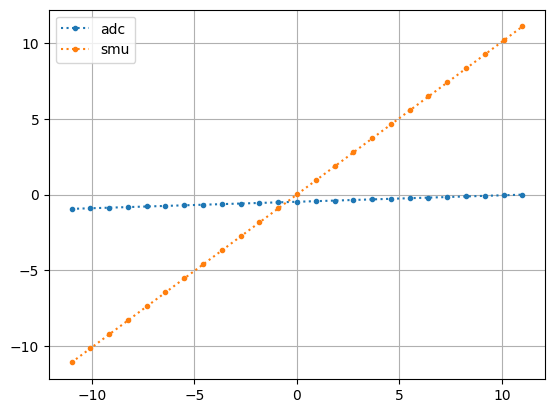


 adc_meas 
 [-9.38589732e-01 -8.99598281e-01 -8.60425790e-01 -8.21444511e-01
 -7.82254378e-01 -7.43195375e-01 -7.03974088e-01 -6.64918582e-01
 -6.25867844e-01 -5.86643855e-01 -5.47558149e-01 -5.08564631e-01
 -4.69312827e-01 -4.30114587e-01 -3.91082128e-01 -3.51974487e-01
 -3.12926769e-01 -2.73777644e-01 -2.34604677e-01 -1.95504665e-01
 -1.56426112e-01 -1.17355982e-01 -7.82701174e-02 -3.91203562e-02
  1.39872233e-05]

 smu_meas 
 [-11.0888   -10.1636    -9.23849   -8.31339   -7.38837   -6.46332
  -5.53812   -4.61317   -3.68812   -2.76298   -1.83804   -0.9129
   0.012064   0.937052   1.86225    2.78728    3.71227    4.63743
   5.56252    6.48725    7.41222    8.33727    9.26242   10.1874
  11.1126  ]
 
Checking if the M and C Values are changed in the registers after Internal Zero Scale Calibration

 Offset after Internal zero Sccale calibration -142

 GAIN0_internal_offset_calibration   1.3334221839904785


100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


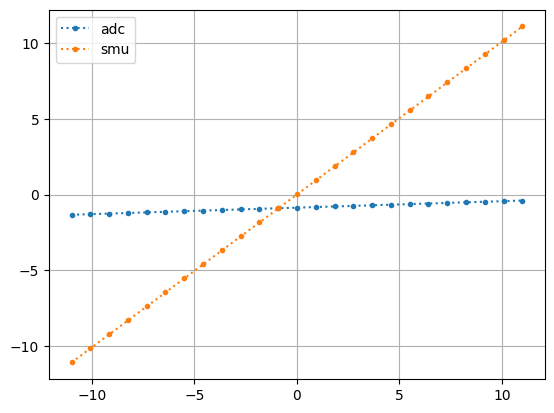


 adc_meas_internal_offset_calibration 
 [-1.32777103 -1.28870281 -1.24967798 -1.21040249 -1.17139896 -1.13234631
 -1.09312201 -1.05404711 -1.0149889  -0.97582626 -0.93665822 -0.89762592
 -0.85849746 -0.81931829 -0.78015296 -0.74109364 -0.7019906  -0.66289759
 -0.62378629 -0.58466832 -0.54554208 -0.50641457 -0.46737067 -0.42819977
 -0.38912169]

 smu_meas_internal_offset_calibration 
 [-11.0888    -10.1636     -9.2386     -8.31352    -7.38847    -6.46335
  -5.53817    -4.61322    -3.68816    -2.76299    -1.83799    -0.912952
   0.0120115   0.937095    1.86223     2.78728     3.71226     4.63741
   5.56253     6.48721     7.4122      8.3373      9.26245    10.1875
  11.1126   ]


100%|██████████| 25/25 [00:02<00:00,  8.58it/s]


 
Checking if the M and C Values are changed in the registers after system Calibration

 OFFSET0_system_offset_calibration -142

 GAIN0_system_offset_calibration   1.3334195613861084


100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


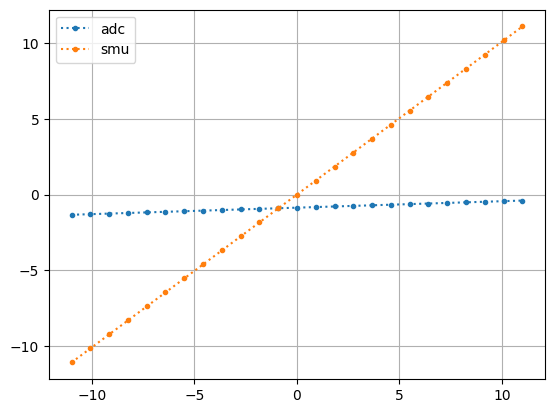


 adc_meas_system_offset_calibration 
 [-1.32760493 -1.28852797 -1.24946833 -1.21044493 -1.17127927 -1.13221169
 -1.09318686 -1.05399307 -1.014901   -0.97572565 -0.93665838 -0.89754407
 -0.85846265 -0.819314   -0.78026136 -0.74109332 -0.70196565 -0.66281207
 -0.62375689 -0.58464988 -0.54556751 -0.50647259 -0.46732155 -0.4282225
 -0.38912582]

 smu_meas_system_offset_calibration 
 [-1.10830e+01 -1.01575e+01 -9.23223e+00 -8.30790e+00 -7.38334e+00
 -6.45855e+00 -5.53356e+00 -4.60873e+00 -3.68373e+00 -2.75861e+00
 -1.83364e+00 -9.08489e-01  7.79152e-03  9.32741e-01  1.85791e+00
  2.78275e+00  3.70764e+00  4.63253e+00  5.55730e+00  6.48136e+00
  7.40623e+00  8.33154e+00  9.25701e+00  1.01825e+01  1.11079e+01]


100%|██████████| 25/25 [00:02<00:00,  8.50it/s]


 
Checking if the M and C Values are changed in the registers after system Gain Calibration

 OFFSET0_system_gain_calibration -1836099

 GAIN0_system_gain_calibration   1.3334195613861084


100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


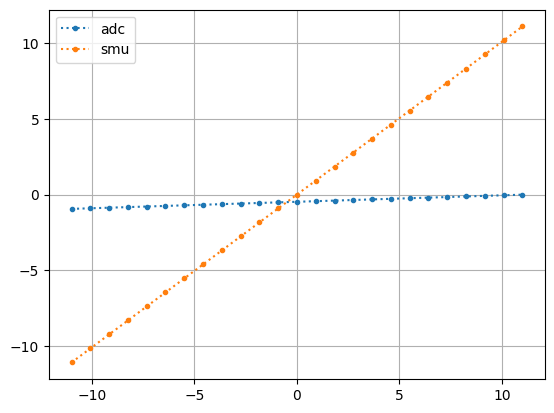


 adc_meas_system_gain_calibration 
 [-9.38601176e-01 -8.99548848e-01 -8.60453129e-01 -8.21299235e-01
 -7.82194614e-01 -7.43092378e-01 -7.04041481e-01 -6.64924145e-01
 -6.25771205e-01 -5.86715539e-01 -5.47613621e-01 -5.08416176e-01
 -4.69330152e-01 -4.30270195e-01 -3.91131878e-01 -3.52021058e-01
 -3.12805176e-01 -2.73716768e-01 -2.34628042e-01 -1.95572853e-01
 -1.56431198e-01 -1.17305438e-01 -7.81911214e-02 -3.91397476e-02
 -2.82923381e-05]

 smu_meas_system_gain_calibration 
 [-1.10827e+01 -1.01572e+01 -9.23185e+00 -8.30757e+00 -7.38303e+00
 -6.45825e+00 -5.53326e+00 -4.60846e+00 -3.68340e+00 -2.75831e+00
 -1.83332e+00 -9.08217e-01  8.12054e-03  9.33065e-01  1.85817e+00
  2.78310e+00  3.70796e+00  4.63285e+00  5.55760e+00  6.48166e+00
  7.40648e+00  8.33189e+00  9.25733e+00  1.01827e+01  1.11080e+01]


In [6]:
# Trying Internal Calibration
p.change_sys_ctrl({
     "DUTGND/CH" : 1,
     "INT10K"    : 1,
     "GAIN"      : 3, #1 #3
     "TMP ENABLE": 1,
     "TMP"       : 3 # Thermal shutdown at 100°C

})

k.smua.source.output = k.smua.OUTPUT_ON
k.display.settext("Ready to do $BStuff$N")
k.display.settext("Trying ADC Internal Calibration")

OFFSET0_without_calibration = p.c.command("adc_read -r 0x30 -l 24", read=True) - 0x800000
GAIN0_without_calibration = p.c.command("adc_read -r 0x38 -l 24", read=True) / 0x400000

print("\nOFFSET0_without_calibration",OFFSET0_without_calibration)
print("\nGAIN0_without_calibration",GAIN0_without_calibration)


adc_meas = list()
smu_meas = list()
v_set = np.linspace(-11, 11, 25)
for v in tqdm(v_set):
    # k.smua.source.levelv = v
    p.channels[0].write_dac(pmu_calc.v_to_dac(v), "FIN_U")
    # sleep(0.1)
    p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
    # sleep(0.1)
    raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
    conv = volt_conversion(raw, bipol)
    conv *= 2/5     # seistive devider
    # conv *= 10      # gain
    adc_meas.append(conv)
    smu_meas.append(k.smua.measure.v())
    # print("A0_in = %sV" % si_format(conv, precision=3))
    
adc_meas = np.array(adc_meas)
smu_meas = np.array(smu_meas)

plt.plot(v_set,adc_meas, ".:", label="adc")
plt.plot(v_set,smu_meas, ".:", label="smu")
plt.legend()
plt.grid()
plt.show()
print("\n adc_meas \n",adc_meas)
print("\n smu_meas \n",smu_meas)





sleep(0.5)

# Comparing Outputs for INTERNAL ZERO-SCALE CALIBRATION MODE,SYSTEM ZERO-SCALE CALIBRATION MODE AND SYSTEM FULL-SCALE CALIBRATION MODE



###################################################################################################################################################################################################################################################################################################

# Trying Internal Offset Calibration

d =  1<<15
d |= 4<<4 # internal offset cal

p.c.command("adc_write -r 0x01 -l 16 -d %i" % d) # Performing Internal Offset Calibration


OFFSET0_internal_offset_calibration = p.c.command("adc_read -r 0x30 -l 24", read=True) - 0x800000
GAIN0_internal_offset_calibration = p.c.command("adc_read -r 0x38 -l 24", read=True) / 0x400000


print(" \nChecking if the M and C Values are changed in the registers after Internal Zero Scale Calibration")
print("\n Offset after Internal zero Sccale calibration",OFFSET0_internal_offset_calibration)
print("\n GAIN0_internal_offset_calibration  ", GAIN0_internal_offset_calibration)

adc_meas_internal_offset_calibration = list()
smu_meas_internal_offset_calibration = list()

# Doing Measurement to compare accuracy with SMU

for v in tqdm(v_set):
    p.channels[0].write_dac(pmu_calc.v_to_dac(v),"FIN_U")
    p.c.command("adc_write -r 0x01 -l 16 -d 0x8010")

    raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
    conv = volt_conversion(raw, bipol)
    conv *= 2/5     # seistive devider  - not exactly sure , why we are using this

    adc_meas_internal_offset_calibration.append(conv)
    smu_meas_internal_offset_calibration.append(k.smua.measure.v())


adc_meas_internal_offset_calibration = np.array(adc_meas_internal_offset_calibration)
smu_meas_internal_offset_calibration = np.array(smu_meas_internal_offset_calibration)

plt.plot(v_set,adc_meas_internal_offset_calibration,".:", label = "adc")
plt.plot(v_set,smu_meas_internal_offset_calibration,".:", label = "smu")
plt.legend()
plt.grid()
plt.show()
k.smua.source.output = k.smua.OUTPUT_OFF

print("\n adc_meas_internal_offset_calibration \n",adc_meas_internal_offset_calibration)
print("\n smu_meas_internal_offset_calibration \n",smu_meas_internal_offset_calibration)


sleep(0.5)

####################################################################################################################################################################################################################################################################################################

# SYSTEM OFFSET CALIBRATION


# Doing Measurement initial to the calibration
for v in tqdm(v_set):
    p.channels[0].write_dac(pmu_calc.v_to_dac(v),"FIN_U")
    p.c.command("adc_write -r 0x01 -l 16 -d 0x8010")
    p.c.command("adc_read -r 0x44 -l 24", True) # get data

# Performing the System Offset Calibration


d =  1<<15
d |= 5<<4 # system offset cal

p.c.command("adc_write -r 0x01 -l 16 -d %i" % d) # Performing system Offset Calibration

OFFSET0_system_offset_calibration = p.c.command("adc_read -r 0x30 -l 24", read=True) - 0x800000
GAIN0_system_offset_calibration = p.c.command("adc_read -r 0x38 -l 24", read=True) / 0x400000


print(" \nChecking if the M and C Values are changed in the registers after system Calibration")
print("\n OFFSET0_system_offset_calibration",OFFSET0_system_offset_calibration)
print("\n GAIN0_system_offset_calibration  ", GAIN0_system_offset_calibration)




adc_meas_system_offset_calibration = list()
smu_meas_system_offset_calibration = list()

# Doing Measurement to compare accuracy with SMU

for v in tqdm(v_set):
    p.channels[0].write_dac(pmu_calc.v_to_dac(v),"FIN_U")
    p.c.command("adc_write -r 0x01 -l 16 -d 0x8010")

    raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
    conv = volt_conversion(raw, bipol)
    conv *= 2/5     # seistive devider  - not exactly sure , why we are using this

    adc_meas_system_offset_calibration.append(conv)
    smu_meas_system_offset_calibration.append(k.smua.measure.v())


adc_meas_system_offset_calibration = np.array(adc_meas_system_offset_calibration)
smu_meas_system_offset_calibration = np.array(smu_meas_system_offset_calibration)

plt.plot(v_set,adc_meas_system_offset_calibration,".:", label = "adc")
plt.plot(v_set,smu_meas_system_offset_calibration,".:", label = "smu")
plt.legend()
plt.grid()
plt.show()
k.smua.source.output = k.smua.OUTPUT_OFF

print("\n adc_meas_system_offset_calibration \n",adc_meas_system_offset_calibration)
print("\n smu_meas_system_offset_calibration \n",smu_meas_system_offset_calibration)

sleep(0.5)

####################################################################################################################################################################################################################################################################################################

# System Gain Calibration

# Doing Measurement initial to the calibration

for v in tqdm(v_set):
    p.channels[0].write_dac(pmu_calc.v_to_dac(v),"FIN_U")
    p.c.command("adc_write -r 0x01 -l 16 -d 0x8010")
    p.c.command("adc_read -r 0x44 -l 24", True) # get data

# Performing the System Gain Calibration

d =  1<<15
d |= 6<<4 # system gain cal

p.c.command("adc_write -r 0x01 -l 16 -d %i" % d) # Performing system Gain Calibration

OFFSET0_system_gain_calibration = p.c.command("adc_read -r 0x30 -l 24", read=True) - 0x800000
GAIN0_system_gain_calibration = p.c.command("adc_read -r 0x38 -l 24", read=True) / 0x400000

print(" \nChecking if the M and C Values are changed in the registers after system Gain Calibration")
print("\n OFFSET0_system_gain_calibration",OFFSET0_system_gain_calibration)
print("\n GAIN0_system_gain_calibration  ", GAIN0_system_gain_calibration)


adc_meas_system_gain_calibration = list()
smu_meas_system_gain_calibration = list()

# Doing Measurement to compare accuracy with SMU

for v in tqdm(v_set):
    p.channels[0].write_dac(pmu_calc.v_to_dac(v),"FIN_U")
    p.c.command("adc_write -r 0x01 -l 16 -d 0x8010")

    raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
    conv = volt_conversion(raw, bipol)
    conv *= 2/5     # seistive devider  - not exactly sure , why we are using this

    adc_meas_system_gain_calibration.append(conv)
    smu_meas_system_gain_calibration.append(k.smua.measure.v())

adc_meas_system_gain_calibration = np.array(adc_meas_system_gain_calibration)
smu_meas_system_gain_calibration = np.array(smu_meas_system_gain_calibration)

plt.plot(v_set,adc_meas_system_gain_calibration,".:", label = "adc")
plt.plot(v_set,smu_meas_system_gain_calibration,".:", label = "smu")
plt.legend()
plt.grid()
plt.show()
k.smua.source.output = k.smua.OUTPUT_OFF

print("\n adc_meas_system_gain_calibration \n",adc_meas_system_gain_calibration)
print("\n smu_meas_system_gain_calibration \n",smu_meas_system_gain_calibration)

sleep(0.5)

####################################################################################################################################################################################################################################################################################################











In [9]:
# C calibration

p.change_sys_ctrl({

    "DUTGND/CH" : 1,
        "INT10K"    : 1,
        "GAIN"      : 3, #1 #3
        "TMP ENABLE": 1,
        "TMP"       : 3 # Thermal shutdown at 100°C

})

k.smua.source.output = k.smua.OUTPUT_ON
k.display.settext("Ready to do some calibration $BStuff$N")
k.display.settext("Trying ADC Offset Calibration Using Interpolation")
# adc_meas_low
# adc_meas_high


##############################################################################################################################################################################################################################   
##################-------For default C Value (0x800000)-----------############################################################################################################################################################
##############################################################################################################################################################################################################################





##############################################################################################################################################################################################################################
# Performing Measurement for x1 = 0X8000

p.c.command("adc_write -r 0x30 -l 24 -d 0x800000")
OFFSET0_LOW = p.c.command("adc_read -r 0x30 -l 24", read=True) 
print("\nOFFSET0_LOW",OFFSET0_LOW)

x1_val = 0X0000

p.channels[0].write_dac(x1_val,"FIN_U")
sleep(0.1)
p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
sleep(0.1)
raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
conv = volt_conversion(raw, bipol)
conv *= 2/5     # seistive devider
# conv *= 10      # gain
volt_for_C_0x800000 = conv
volt_for_ideal = k.smua.measure.v()


# Print Statements for Debugging
print("\n Values for default C Value")
print("\n Current OFFSET0 Value: ",OFFSET0_LOW)
print("\n Measurement Input Value : ",x1_val)
print("\n Ideal value measured by the SMU for reference : ",volt_for_ideal)
print("\n ADC output converted to volts : ",volt_for_C_0x800000)


sleep(0.5)


##################################################################################################################################################################################################################################   
##################-------For  C  Maximum Value (0xFFFFFF)-----------##############################################################################################################################################################
##################################################################################################################################################################################################################################

# Writing C value 0xFFFFFF

p.c.command("adc_write -r 0x30 -l 24 -d 0xFFFFFF")
OFFSET0_HIGH = p.c.command("adc_read -r 0x30 -l 24", read=True)
print("\nOFFSET0_HIGH",OFFSET0_HIGH)

p.channels[0].write_dac(x1_val,"FIN_U")
sleep(0.1)
p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
sleep(0.1)
raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
conv = volt_conversion(raw, bipol)
conv *= 2/5     # seistive devider
# conv *= 10      # gain
volt_for_C_0xFFFFFF = conv

# Print Statements for Debugging
print("\n Values for 0xFFFFFF C Value")
print("\n Current OFFSET0 Value: ",OFFSET0_HIGH)
print("\n Measurement Input Value : ",x1_val)
print("\n Ideal value measured by the SMU for reference : ",volt_for_ideal)
print("\n ADC output converted to volts : ",volt_for_C_0xFFFFFF)



#k.smua.source.output = k.smua.OUTPUT_OFF


# # Arranging Variables for Interpolation

# dac_zero = OFFSET0_HIGH
# dac_one = OFFSET0_LOW
# volt_zero = volt_for_C_0x800000
# volt_one = volt_for_C_0xFFFFFF              
# v_req = volt_for_ideal

# print("\ndacc_zero",dac_zero)
# print("\ndac_one",dac_one)
# print("\nvolt_zero",volt_zero)
# print("\nvolt_one",volt_one)
# print("\nv_req",v_req)

# x_zero_c,y_zero_c,x_one_c,y_one_c,y_required_c = dac_zero,volt_zero,dac_one,volt_one,v_req
       
        
# #Calibration using linear interpolation for "C"
# # Calculate the numerator and denominator for interpolation
# numerator = (x_one_c - x_zero_c) * (y_required_c - y_zero_c)
# denominator = y_one_c - y_zero_c

# #Perform interpolation
# x_required_c = round(x_zero_c + numerator / denominator)  

# print(f"The offset for output voltage {y_required_c} is approximately {x_required_c:.15f}.")


# OFFSET0_NEW = x_required_c


# # Writing the new calibrated OFFSET0 and checking the accuracy

# p.c.command("adc_write -r 0x30 -l 24 -d %i " % OFFSET0_NEW)

# p.channels[0].write_dac(x1_val,"FIN_U")
# sleep(0.1)
# p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
# sleep(0.1)
# raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
# conv = volt_conversion(raw, bipol)
# conv *= 2/5     # seistive devider
# # conv *= 10      # gain
# volt_for_C_after_calibration = conv

# print("\n voltage after Calibration : ",volt_for_C_after_calibration)

# k.smua.source.output        = k.smua.OUTPUT_OFF











OFFSET0_LOW 8388608

 Values for default C Value

 Current OFFSET0 Value:  8388608

 Measurement Input Value :  0

 Ideal value measured by the SMU for reference :  -11.2272

 ADC output converted to volts :  -1.3333333333333335

OFFSET0_HIGH 16777215

 Values for 0xFFFFFF C Value

 Current OFFSET0 Value:  16777215

 Measurement Input Value :  0

 Ideal value measured by the SMU for reference :  -11.2272

 ADC output converted to volts :  -1.3333333333333335



Current Offset None


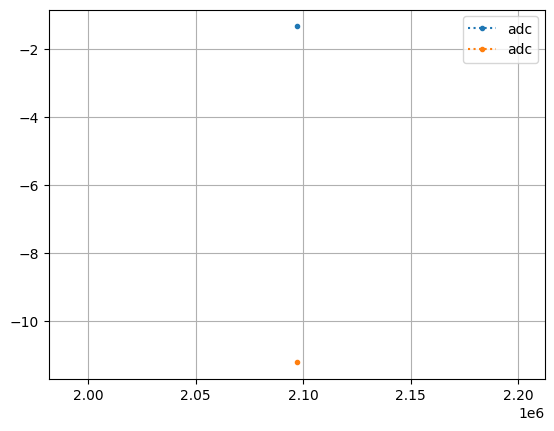

In [15]:
p.change_sys_ctrl({

    "DUTGND/CH" : 1,
        "INT10K"    : 1,
        "GAIN"      : 3, #1 #3
        "TMP ENABLE": 1,
        "TMP"       : 3 # Thermal shutdown at 100°C

})

k.smua.source.output = k.smua.OUTPUT_ON

# Trying C values from 0 to 0X8000
offset_set_one = 0x200000 
x1_value = 0x0000
adc_output = list()
smu_output = list()


sleep (0.5)
current_offset = p.c.command("adc_write -r 0x30 -l 24 -d offset_set_one ")
print("\nCurrent Offset",current_offset)
sleep(0.1)

# Performing Measurement for one X1 value
p.channels[0].write_dac(x1_value,"FIN_U")
sleep(0.1)
p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
sleep(0.1)
raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
conv = volt_conversion(raw, bipol)
conv *= 2/5     # seistive devider
# conv *= 10      # gain
    
adc_output.append(conv)
smu_output.append(k.smua.measure.v())

adc_output = np.array(adc_output)
smu_output = np.array(smu_output)

plt.plot(offset_set_one,adc_output,".:",label = "adc")
plt.plot(offset_set_one,smu_output,".:",label = "adc")
plt.legend()
plt.grid()
plt.show()
k.smua.source.output = k.smua.OUTPUT_OFF









Current Offset None

Current Offset None

Current Offset None

Current Offset None

Current Offset None

Current Offset None

Current Offset None

Current Offset None

Current Offset None


ValueError: x and y must have same first dimension, but have shapes (1,) and (9,)

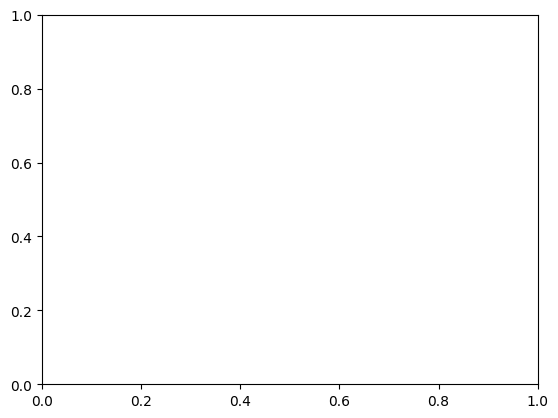

In [12]:
p.change_sys_ctrl({

    "DUTGND/CH" : 1,
        "INT10K"    : 1,
        "GAIN"      : 3, #1 #3
        "TMP ENABLE": 1,
        "TMP"       : 3 # Thermal shutdown at 100°C

})

k.smua.source.output = k.smua.OUTPUT_ON

# Trying C values from 0 to 0X8000
offset_range = np.arange(0x0, 0x800001, 0x100000)
x1_value = 0x0000
x1_value = 0x0000
adc_output = list()
smu_output = list()

for offset_set_one in offset_range:
    sleep (0.5)
    current_offset = p.c.command(f"adc_write -r 0x30 -l 24 -d {hex(offset_set_one)}")
    print("\nCurrent Offset",current_offset)
    sleep(0.1)

    # Performing Measurement for one X1 value
    p.channels[0].write_dac(x1_value,"FIN_U")
    sleep(0.1)
    p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
    sleep(0.1)
    raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
    conv = volt_conversion(raw, bipol)
    conv *= 2/5     # seistive devider
    # conv *= 10      # gain
    adc_output.append(conv)
    smu_output.append(k.smua.measure.v())

adc_output = np.array(adc_output)
smu_output = np.array(smu_output)

plt.plot(offset_set_one,adc_output,".:",label = "adc")
plt.plot(offset_set_one,smu_output,".:",label = "adc")
plt.legend()
plt.grid()
plt.show()
k.smua.source.output = k.smua.OUTPUT_OFF









# This will produce a graph that compares the ouput of the adc for a specific x1 value for the offset values from 0x000000 to ox800000









OFFSET0_LOW 0

OFFSET0_HIGH 8388607


C:\Users\jbabraham\AppData\Local\Temp\ipykernel_1928\51658817.py:175: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p.c.command("adc_write -r 0x30 -l 24 -d %i " % OFFSET0_NEW)



slope_Max 0.0

slope_Min 1.4499558520689865e-05

slope_Ideal 0.0003429906369212928
[-1.90045963e+08]

Offset after Interpolation [-1.90045963e+08]


100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


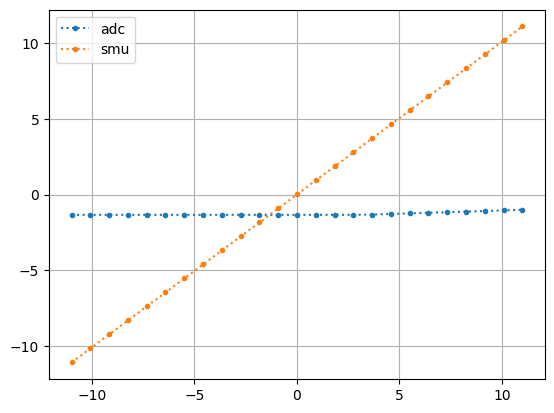

In [13]:
# C calibration With Slope

p.change_sys_ctrl({

    "DUTGND/CH" : 1,
        "INT10K"    : 1,
        "GAIN"      : 3, #1 #3
        "TMP ENABLE": 1,
        "TMP"       : 3 # Thermal shutdown at 100°C

})

k.smua.source.output = k.smua.OUTPUT_ON
k.display.settext("Ready to do some calibration $BStuff$N")
k.display.settext("Trying ADC Offset Calibration Using Interpolation")
# adc_meas_low
# adc_meas_high


##############################################################################################################################################################################################################################   
##################-------For default C Value (0x800000)-----------############################################################################################################################################################
##############################################################################################################################################################################################################################

##############################################################################################################################################################################################################################
# Performing Measurement for x1 = 0X8000

OFFSET0_LOW = p.c.command("adc_read -r 0x30 -l 24", read=True) - 0x800000
print("\nOFFSET0_LOW",OFFSET0_LOW)

x1_val_min = 0X8000
x1_val_max = 0XFFFF


# Performing Measurement for x1_val_min

p.channels[0].write_dac(x1_val_min,"FIN_U")
sleep(0.1)
p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
sleep(0.1)
raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
conv = volt_conversion(raw, bipol)
conv *= 2/5     # seistive devider
# conv *= 10      # gain
volt_min_for_C_0x800000 = conv
volt_min_for_ideal = k.smua.measure.v()

# Performing Measurement for x1_val_max

sleep(0.1)
p.channels[0].write_dac(x1_val_max,"FIN_U")
sleep(0.1)
p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
sleep(0.1)
raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
conv = volt_conversion(raw, bipol)
conv *= 2/5     # seistive devider
# conv *= 10      # gain
volt_max_for_C_0x800000 = conv
volt_max_for_ideal = k.smua.measure.v()







# # Print Statements for Debugging
# print("\n Values for default C Value")
# print("\n Current OFFSET0 Value: ",OFFSET0_LOW)
# print("\n Measurement Input Value : ",x1_val)
# print("\n Ideal value measured by the SMU for reference : ",volt_for_ideal)
# print("\n ADC output converted to volts : ",volt_for_C_0x800000)

##################################################################################################################################################################################################################################   
##################-------For  C  Maximum Value (0xFFFFFF)-----------##############################################################################################################################################################
##################################################################################################################################################################################################################################

# Writing C value 0xFFFFFF

p.c.command("adc_write -r 0x30 -l 24 -d 0xFFFFFF")
OFFSET0_HIGH = p.c.command("adc_read -r 0x30 -l 24", read=True) - 0x800000
print("\nOFFSET0_HIGH",OFFSET0_HIGH)

# Performing Measurement for x1_val_min

p.channels[0].write_dac(x1_val_min,"FIN_U")
sleep(0.1)
p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
sleep(0.1)
raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
conv = volt_conversion(raw, bipol)
conv *= 2/5     # seistive devider
# conv *= 10      # gain
volt_min_for_C_0xFFFFFF  = conv

# Performing Measurement for x1_val_max

sleep(0.1)
p.channels[0].write_dac(x1_val_max,"FIN_U")
sleep(0.1)
p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
sleep(0.1)
raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
conv = volt_conversion(raw, bipol)
conv *= 2/5     # seistive devider
# conv *= 10      # gain
volt_max_for_C_0xFFFFFF = conv



##################################################################################################################################################################################################################################



#Arranging Variables for Interpolation

# For Calculating Slope for C 0x800000

(x_one_for_C_0x800000,y_one_for_C_0x800000) = (x1_val_min,volt_min_for_C_0x800000)
(x_two_for_C_0x800000,y_two_for_C_0x800000) = (x1_val_max,volt_max_for_C_0x800000)

#For Slope for C 0xFFFFFF
(x_one_for_C_0xFFFFFF,y_one_for_C_0xFFFFFF) = (x1_val_min,volt_min_for_C_0xFFFFFF)
(x_two_for_C_0xFFFFFF,y_two_for_C_0xFFFFFF) = (x1_val_max,volt_max_for_C_0xFFFFFF)

#For Slope For Ideal M using the equation
(x_one_for_C_Ideal,y_one_for_C_Ideal) = (x1_val_min,volt_min_for_ideal)
(x_two_for_C_Ideal,y_two_for_C_Ideal) = (x1_val_max,volt_max_for_ideal)

##################################################################################################################################################################################################################################

# 3 Slopes required for interpolation

slope_Max = (y_two_for_C_0xFFFFFF - y_one_for_C_0xFFFFFF) / (x_two_for_C_0xFFFFFF - x_one_for_C_0xFFFFFF)
print("\nslope_Max",slope_Max)

slope_Min = (y_two_for_C_0x800000 - y_one_for_C_0x800000) / (x_two_for_C_0x800000 - x_one_for_C_0x800000)
print("\nslope_Min",slope_Min)

slope_Ideal = (y_two_for_C_Ideal - y_one_for_C_Ideal) / (x_two_for_C_Ideal - x_one_for_C_Ideal)
print("\nslope_Ideal",slope_Ideal)

##################################################################################################################################################################################################################################

# Performing Interpolation

dac_min = OFFSET0_LOW
dac_max = OFFSET0_HIGH

x = np.array([ slope_Min, slope_Max])  # Comparing For Interpolation
y = np.array([dac_min,dac_max])
 
    
model = np.polyfit(x, y, 1)  # Fit a linear line to the known data points
 
    
new_x = np.array([ slope_Ideal]) # New x values for which to extrapolate the y values
 
   
new_y = np.polyval(model, new_x)  # Extrapolate the y values for the new x values
 
print(new_y)
print("\nOffset after Interpolation",new_y)
NEW_FIN_I_M_FINAL = new_y

if NEW_FIN_I_M_FINAL > 0xFFFFFF:
    NEW_FIN_I_M_FINAL = 0xFFFFFF


OFFSET0_NEW = NEW_FIN_I_M_FINAL


# Writing the new calibrated OFFSET0 and checking the accuracy

p.c.command("adc_write -r 0x30 -l 24 -d %i " % OFFSET0_NEW)

adc_meas = list()
smu_meas = list()
v_set = np.linspace(-11, 11, 25)

for v in tqdm(v_set):
    # k.smua.source.levelv = v
    p.channels[0].write_dac(pmu_calc.v_to_dac(v), "FIN_U")
    # sleep(0.1)
    p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
    # sleep(0.1)
    raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
    conv = volt_conversion(raw, bipol)
    conv *= 2/5     # seistive devider
    # conv *= 10      # gain
    adc_meas.append(conv)
    smu_meas.append(k.smua.measure.v())
    # print("A0_in = %sV" % si_format(conv, precision=3))
    
adc_meas = np.array(adc_meas)
smu_meas = np.array(smu_meas)

plt.plot(v_set,adc_meas, ".:", label="adc")
plt.plot(v_set,smu_meas, ".:", label="smu")
plt.legend()
plt.grid()
plt.show()
k.smua.source.output        = k.smua.OUTPUT_OFF

















gain zero low 1.3335151672363281

gain zero high 3.999999761581421


C:\Users\jbabraham\AppData\Local\Temp\ipykernel_1928\1087861999.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p.c.command("adc_write -r 0x30 -l 24 -d %i " % OFFSET0_NEW)



slope_Max 0.0

slope_Min 1.4499558520689865e-05

slope_Ideal 0.0003429906369212928
[-1.90045963e+08]

Offset after Interpolation [-1.90045963e+08]


100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


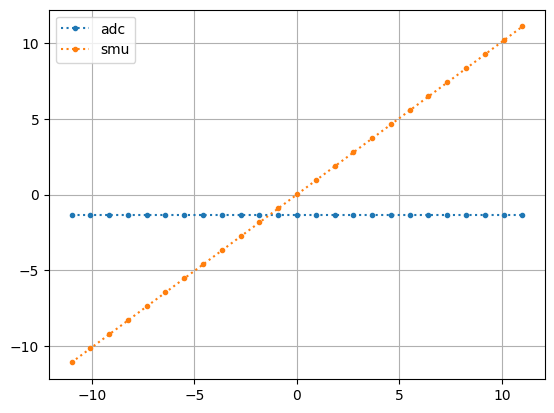

In [14]:
# M Calibration With Slope

p.change_sys_ctrl({

    "DUTGND/CH" : 1,
        "INT10K"    : 1,
        "GAIN"      : 3, #1 #3
        "TMP ENABLE": 1,
        "TMP"       : 3 # Thermal shutdown at 100°C

})

k.smua.source.output = k.smua.OUTPUT_ON
k.display.settext("Ready to do some calibration $BStuff$N")
k.display.settext("Trying ADC Offset Calibration Using Interpolation")
# adc_meas_low
# adc_meas_high

##############################################################################################################################################################################################################################   
##################-------For default M Value ( 0x555555)-----------############################################################################################################################################################
##############################################################################################################################################################################################################################

gain_zero_low = p.c.command("adc_read -r 0X38  -l 24 ", read = True) / 0x400000
print("\ngain zero low",gain_zero_low)

x1_val_min = 0X8000
x1_val_max = 0XFFFF

# Performing Measurement for x1_val_min
p.channels[0].write_dac(x1_val_min,"FIN_U")
sleep(0.1)
p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
sleep(0.1)
raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
conv = volt_conversion(raw, bipol)
conv *= 2/5     # seistive devider
# conv *= 10      # gain
volt_min_for_M_0x555555 = conv
volt_min_for_ideal = k.smua.measure.v()


# Performing Measurement for x1_val_max

sleep(0.1)
p.channels[0].write_dac(x1_val_max,"FIN_U")
sleep(0.1)
p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
sleep(0.1)
raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
conv = volt_conversion(raw, bipol)
conv *= 2/5     # seistive devider
# conv *= 10      # gain
volt_max_for_M_0x555555 = conv
volt_max_for_ideal = k.smua.measure.v()

##################################################################################################################################################################################################################################   
##################-------For  M  Maximum Value (0xFFFFFF)-----------##############################################################################################################################################################
##################################################################################################################################################################################################################################

# Writing M value 0xFFFFFF

p.c.command("adc_write -r 0x38 -l 24 -d 0xFFFFFF")

gain_zero_high = p.c.command("adc_read -r 0X38  -l 24 ", read = True) / 0x400000
print("\ngain zero high",gain_zero_high)

# Performing Measurement for x1_val_min

p.channels[0].write_dac(x1_val_min,"FIN_U")
sleep(0.1)
p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
sleep(0.1)
raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
conv = volt_conversion(raw, bipol)
conv *= 2/5     # seistive devider
# conv *= 10      # gain
volt_min_for_M_0xFFFFFF = conv

# Performing Measurement for x1_val_max

sleep(0.1)
p.channels[0].write_dac(x1_val_max,"FIN_U")
sleep(0.1)
p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
sleep(0.1)
raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
conv = volt_conversion(raw, bipol)
conv *= 2/5     # seistive devider
# conv *= 10      # gain
volt_max_for_M_0xFFFFFF = conv


##################################################################################################################################################################################################################################



#Arranging Variables for Interpolation

# For Calculating Slope for C 0x800000

(x_one_for_M_0x555555,y_one_for_M_0x555555) = (x1_val_min,volt_min_for_M_0x555555)
(x_two_for_M_0x555555,y_two_for_M_0x555555) = (x1_val_max,volt_max_for_M_0x555555)

#For Slope for C 0xFFFFFF
(x_one_for_M_0xFFFFFF,y_one_for_M_0xFFFFFF) = (x1_val_min,volt_min_for_M_0xFFFFFF)
(x_two_for_M_0xFFFFFF,y_two_for_M_0xFFFFFF) = (x1_val_max,volt_max_for_M_0xFFFFFF)

#For Slope For Ideal M using the equation
(x_one_for_M_Ideal,y_one_for_M_Ideal) = (x1_val_min,volt_min_for_ideal)
(x_two_for_M_Ideal,y_two_for_M_Ideal) = (x1_val_max,volt_max_for_ideal)

##################################################################################################################################################################################################################################

# 3 Slopes required for interpolation

slope_Max = (y_two_for_C_0xFFFFFF - y_one_for_C_0xFFFFFF) / (x_two_for_C_0xFFFFFF - x_one_for_C_0xFFFFFF)
print("\nslope_Max",slope_Max)

slope_Min = (y_two_for_C_0x800000 - y_one_for_C_0x800000) / (x_two_for_C_0x800000 - x_one_for_C_0x800000)
print("\nslope_Min",slope_Min)

slope_Ideal = (y_two_for_C_Ideal - y_one_for_C_Ideal) / (x_two_for_C_Ideal - x_one_for_C_Ideal)
print("\nslope_Ideal",slope_Ideal)

##################################################################################################################################################################################################################################


# Performing Interpolation

dac_min = OFFSET0_LOW
dac_max = OFFSET0_HIGH

x = np.array([ slope_Min, slope_Max])  # Comparing For Interpolation
y = np.array([dac_min,dac_max])
 
    
model = np.polyfit(x, y, 1)  # Fit a linear line to the known data points
 
    
new_x = np.array([ slope_Ideal]) # New x values for which to extrapolate the y values
 
   
new_y = np.polyval(model, new_x)  # Extrapolate the y values for the new x values
 
print(new_y)
print("\nOffset after Interpolation",new_y)
NEW_FIN_I_M_FINAL = new_y

if NEW_FIN_I_M_FINAL > 0xFFFFFF:
    NEW_FIN_I_M_FINAL = 0xFFFFFF


OFFSET0_NEW = NEW_FIN_I_M_FINAL


# Writing the new calibrated OFFSET0 and checking the accuracy

p.c.command("adc_write -r 0x30 -l 24 -d %i " % OFFSET0_NEW)

adc_meas = list()
smu_meas = list()
v_set = np.linspace(-11, 11, 25)

for v in tqdm(v_set):
    # k.smua.source.levelv = v
    p.channels[0].write_dac(pmu_calc.v_to_dac(v), "FIN_U")
    # sleep(0.1)
    p.c.command("adc_write -r 0x01 -l 16 -d 0x8010") # do single conversion
    # sleep(0.1)
    raw = p.c.command("adc_read -r 0x44 -l 24", True) # get data
    conv = volt_conversion(raw, bipol)
    conv *= 2/5     # seistive devider
    # conv *= 10      # gain
    adc_meas.append(conv)
    smu_meas.append(k.smua.measure.v())
    # print("A0_in = %sV" % si_format(conv, precision=3))
    
adc_meas = np.array(adc_meas)
smu_meas = np.array(smu_meas)

plt.plot(v_set,adc_meas, ".:", label="adc")
plt.plot(v_set,smu_meas, ".:", label="smu")
plt.legend()
plt.grid()
plt.show()
k.smua.source.output        = k.smua.OUTPUT_OFF



